In [1]:
import numpy as np
from neural_network.layer import *
from neural_network.net import *
from queue import Queue
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_network.trainutils import Dataset, PCADataset, train_test_split
import os
import seaborn as sns

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
dataset = PCADataset(face_dir)

In [3]:
dataset.data.shape

(624, 68, 1)

In [4]:
img = dataset.data[0]

In [5]:
dataset.orig_shape

(120, 128)

(68, 1)
(68, 15360)
(120, 128)
(120, 128)


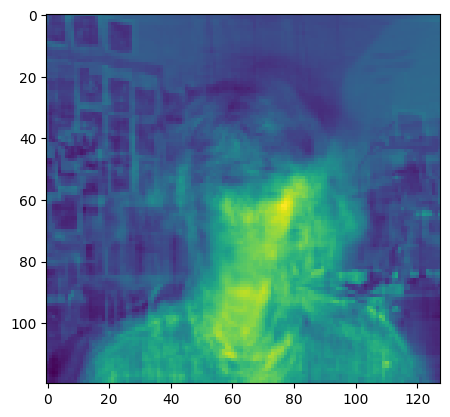

In [6]:
recon = dataset.get_reconstructed_image(0)
print(recon.shape)
plt.imshow(recon)

In [7]:
train, validation, test = train_test_split(dataset, (0.8, 0.0, 0.2))

In [8]:
train.label

array([0, 0, 2, 1, 2, 3, 3, 2, 3, 0, 3, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 1,
       3, 3, 2, 3, 0, 2, 1, 3, 2, 3, 0, 2, 0, 1, 3, 0, 1, 3, 0, 3, 1, 0,
       1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 2, 0, 0, 1, 2, 2, 0, 2, 2, 3, 2, 0,
       2, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 0, 2,
       1, 0, 2, 1, 1, 1, 3, 2, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 1, 0, 1, 2,
       3, 2, 0, 1, 0, 3, 1, 0, 3, 3, 3, 1, 2, 0, 3, 0, 2, 1, 1, 0, 0, 0,
       3, 1, 2, 1, 1, 1, 2, 3, 3, 0, 1, 0, 0, 1, 1, 2, 3, 2, 0, 0, 2, 1,
       3, 3, 1, 1, 3, 3, 1, 2, 2, 0, 3, 1, 2, 1, 3, 0, 3, 1, 1, 3, 0, 1,
       2, 0, 2, 2, 2, 2, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3,
       2, 2, 1, 3, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 3, 3, 1, 1, 0,
       0, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 1, 3, 2, 1, 2, 0, 0, 0, 3, 2, 2,
       1, 0, 2, 3, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 2, 0, 1, 3, 0, 0,
       2, 0, 2, 3, 1, 3, 0, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 1, 2, 0, 2, 0,
       3, 0, 3, 0, 1, 3, 0, 2, 2, 0, 1, 3, 3, 0, 3,

In [9]:
input_shape = train[0][0].shape[0]

In [10]:
input_shape

68

In [11]:
linear1 = Linear(input_shape, input_shape//2)
relu1 = ReLU(linear1)
linear2 = Linear(input_shape//2, input_shape//4, relu1)
relu2 = ReLU(linear2)
linear3 = Linear(input_shape//4, input_shape//8, relu2)
relu3 = ReLU(linear3)
linear4 = Linear(input_shape//8, input_shape//16, relu3)
relu4 = ReLU(linear4)
linear5 = Linear(input_shape//16, len(dataset.keys), relu4)
softmaxlayer = Softmax(linear5)
loss_layer = CrossEntropy(softmaxlayer)

model = NeuralNetwork(linear1, softmaxlayer, loss_layer)

In [12]:
print(model.n_layers)
print(model.output_layer)

print("Forward order:")
for layer in model._forward_order:
    print(layer)

print("\nBackward order:")
for layer in model._backward_order:
    print(layer)

11
Forward order:
Linear: (68, 1) -> (34, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (4, 1) -> (4, 1)
Softmax
CrossEntropy

Backward order:
CrossEntropy
Softmax
Linear: (4, 1) -> (4, 1)
ReLU
Linear: (8, 1) -> (4, 1)
ReLU
Linear: (17, 1) -> (8, 1)
ReLU
Linear: (34, 1) -> (17, 1)
ReLU
Linear: (68, 1) -> (34, 1)


In [13]:
loss_array = []
pbar = tqdm(range(2500))
for i in pbar:
    epoch_loss = 0
    for data, label in train:
        data = data.reshape(-1, 1)
        out = model.forward(data)
        #print(out)
        loss = model.loss_layer.forward(out, label)
        epoch_loss += loss
        model.backward()
        model.step()
    epoch_loss = epoch_loss / len(train)
    loss_array.append(epoch_loss)
    pbar.set_description(str(epoch_loss))

[2.05921044e-05]: 100%|██████████| 2500/2500 [05:20<00:00,  7.80it/s]


In [14]:
loss_array

[array([1.42959419]),
 array([1.35052232]),
 array([1.27725381]),
 array([1.20450065]),
 array([1.13561503]),
 array([1.07349342]),
 array([1.01704804]),
 array([0.96728886]),
 array([0.92359487]),
 array([0.88144335]),
 array([0.83861692]),
 array([0.79559702]),
 array([0.75337402]),
 array([0.71063127]),
 array([0.66613212]),
 array([0.62078165]),
 array([0.57624349]),
 array([0.53149706]),
 array([0.48793805]),
 array([0.44414977]),
 array([0.40072502]),
 array([0.35948359]),
 array([0.32171774]),
 array([0.28795501]),
 array([0.25665291]),
 array([0.22983377]),
 array([0.2076986]),
 array([0.18862382]),
 array([0.17150939]),
 array([0.15585311]),
 array([0.13960151]),
 array([0.12434868]),
 array([0.11126484]),
 array([0.09928304]),
 array([0.08645113]),
 array([0.07381666]),
 array([0.06441016]),
 array([0.05735211]),
 array([0.05081409]),
 array([0.04630335]),
 array([0.04123751]),
 array([0.03685599]),
 array([0.0332415]),
 array([0.03045744]),
 array([0.02805293]),
 array([0.02

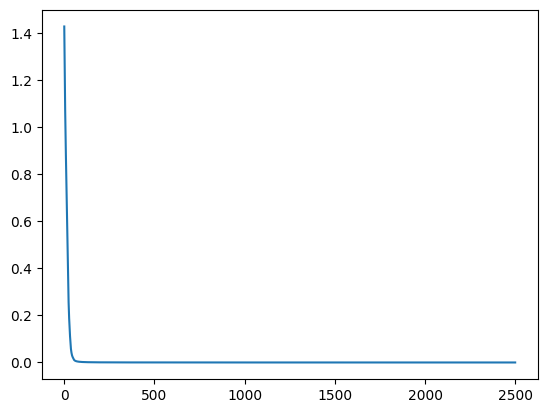

In [15]:
plt.plot(loss_array)

In [16]:
train.label

array([0, 0, 2, 1, 2, 3, 3, 2, 3, 0, 3, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 1,
       3, 3, 2, 3, 0, 2, 1, 3, 2, 3, 0, 2, 0, 1, 3, 0, 1, 3, 0, 3, 1, 0,
       1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 2, 0, 0, 1, 2, 2, 0, 2, 2, 3, 2, 0,
       2, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 0, 2,
       1, 0, 2, 1, 1, 1, 3, 2, 3, 0, 3, 3, 2, 3, 3, 3, 3, 0, 1, 0, 1, 2,
       3, 2, 0, 1, 0, 3, 1, 0, 3, 3, 3, 1, 2, 0, 3, 0, 2, 1, 1, 0, 0, 0,
       3, 1, 2, 1, 1, 1, 2, 3, 3, 0, 1, 0, 0, 1, 1, 2, 3, 2, 0, 0, 2, 1,
       3, 3, 1, 1, 3, 3, 1, 2, 2, 0, 3, 1, 2, 1, 3, 0, 3, 1, 1, 3, 0, 1,
       2, 0, 2, 2, 2, 2, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3,
       2, 2, 1, 3, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 3, 3, 1, 1, 0,
       0, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 1, 3, 2, 1, 2, 0, 0, 0, 3, 2, 2,
       1, 0, 2, 3, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 2, 0, 1, 3, 0, 0,
       2, 0, 2, 3, 1, 3, 0, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 1, 2, 0, 2, 0,
       3, 0, 3, 0, 1, 3, 0, 2, 2, 0, 1, 3, 3, 0, 3,

accuracy: 1.0


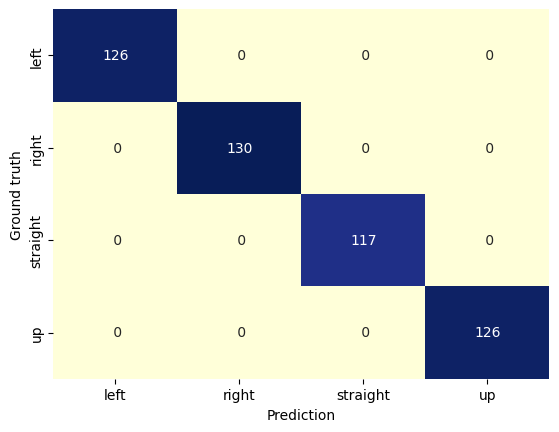

In [17]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in train:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
#plt.title(f"")
plt.show()

accuracy: 0.912


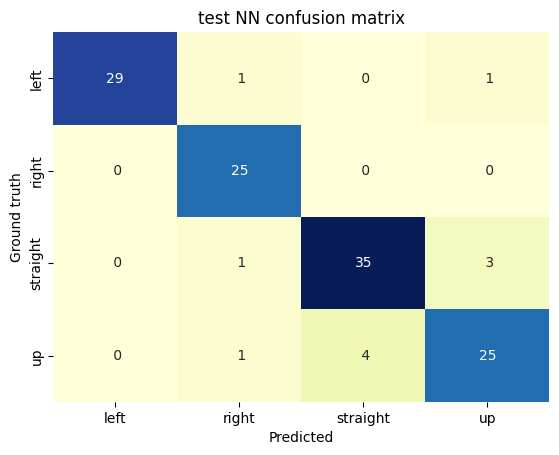

In [18]:
confusion_matrix = np.zeros(shape=[len(dataset.keys)]*2)
for data, label in test:
    data = data.reshape(-1, 1)
    out = model.forward(data)
    #print(out)
    loss = model.loss_layer.forward(out, label)
    confusion_matrix[np.argmax(label), np.argmax(out)] += 1
    epoch_loss += loss
print(f"accuracy: {confusion_matrix.trace()/confusion_matrix.sum()}")

plt.figure()
sns.heatmap(confusion_matrix.astype(int), annot=True, cbar=False, xticklabels=dataset.keys, yticklabels=dataset.keys, cmap="YlGnBu", fmt="2d")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.title(f"test NN confusion matrix")
plt.show()

In [19]:
train[0][0].shape

(68,)

In [20]:
dataset.eig_idx

68